Import Libraries

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Dropout

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Sentinel-2 Bands

In [ ]:
# Calculate NDVI
def calculate_ndvi(b08_path, b04_path):
    # Read Satellite Image
    with rasterio.open(b08_path) as nir_src:
        nir = nir_src.read(1).astype('float32')
    with rasterio.open(b04_path) as red_src:
        red = red_src.read(1).astype('float32')
    # Calculating NDVI
    ndvi =  (nir - red) / (nir + red + 1e-6)
    return ndvi

Satellite Image 2017

In [ ]:
# Satellite Image Path 2017
band04_2017 = '/content/drive/MyDrive/T40RCN_20170613T064621_B04_10m.jp2'
band08_2017 = '/content/drive/MyDrive/T40RCN_20170613T064621_B08_10m.jp2'

In [ ]:
ndvi_2017 = calculate_ndvi(band08_2017, band04_2017)

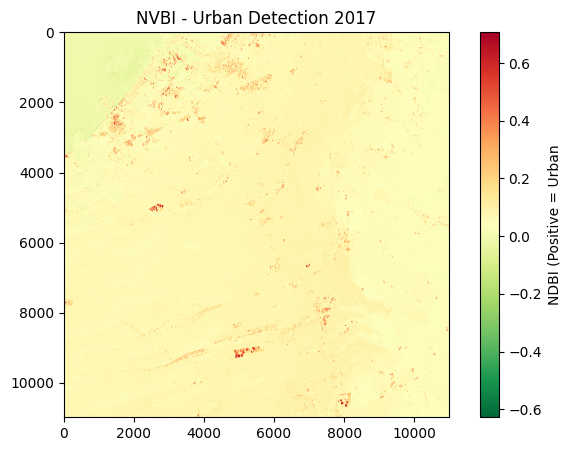

In [ ]:
# Draw Results Of 2017
plt.figure(figsize=(8, 5))
plt.title('NDVI - Urban Detection 2017')
plt.imshow(ndvi_2017, cmap='RdYlGn_r')
plt.colorbar(label='NDBI (Positive = Urban')
plt.show()

Satellite Image 2025

In [ ]:
# Satellite Image Path 2025
band04_2025 = '/content/drive/MyDrive/T40RCN_20250611T064641_B04_10m.jp2'
band08_2025 = '/content/drive/MyDrive/T40RCN_20250611T064641_B08_10m.jp2'

In [ ]:
ndvi_2025 = calculate_ndvi(band08_2025, band04_2025)

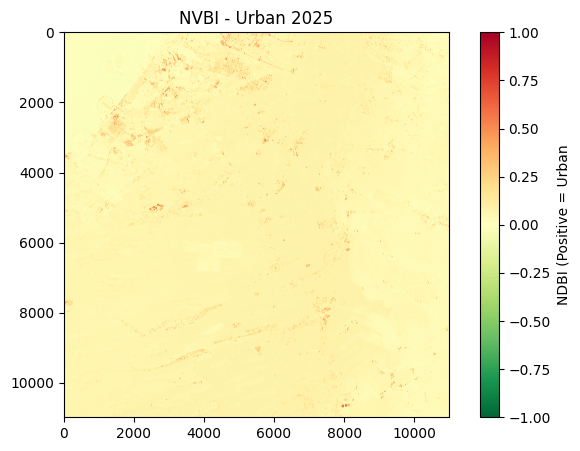

In [ ]:
# Draw Results Of 2017
plt.figure(figsize=(8, 5))
plt.title('NDVI - Urban 2025')
plt.imshow(ndvi_2025, cmap='RdYlGn_r')
plt.colorbar(label='NDBI (Positive = Urban')
plt.show()

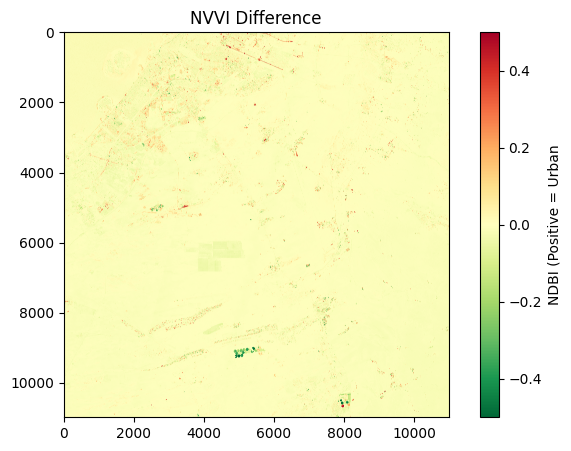

In [ ]:
# Calculate NDVI_Diffenrent
ndvi_diff = ndvi_2025 - ndvi_2017

# Draw Results Of NDVI Difference
plt.figure(figsize=(8, 5))
plt.title('NDVI Difference')
plt.imshow(ndvi_diff, cmap='RdYlGn_r', vmin=-0.5, vmax=0.5)
plt.colorbar(label='NDBI (Positive = Urban')
plt.show()

Generat Urabn Change Mask

In [ ]:
# Mark Only Areas Where Significant Urbanization Has Occurred
threshold = 0.2
change_mask = np.abs(ndvi_diff > threshold)

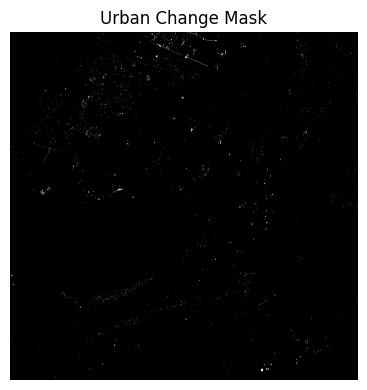

In [ ]:
plt.figure(figsize=(8,4))
plt.title('Urban Change Mask')
plt.imshow(change_mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print('ndvi_2017 shape:', ndvi_2017.shape)
print('ndvi_2025 shape:', ndvi_2025.shape)
print(np.mean(change_mask)* 100, '%')

ndvi_2017 shape: (10980, 10980)
ndvi_2025 shape: (10980, 10980)
0.30891901486723666 %


Create Patches (Data Preprocessing & Cleaning)

In [ ]:
def create_patches(ndvi_old, ndvi_new, change_mask, patch_size=256, stride=256):
    X_patches = []
    y_patches = []

    h, w = ndvi_old.shape

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            # Cut Patches Of New, Old NDVI
            patch_old = ndvi_old[i:i+patch_size, j:j+patch_size]
            patch_new = ndvi_new[i:i+patch_size, j:j+patch_size]
            patch_mask = change_mask[i:i+patch_size, j:j+patch_size]

            # Combine old, new patch
            patch_input = np.stack([patch_old, patch_new], axis=-1)

            X_patches.append(patch_input)
            y_patches.append(patch_mask)

    X_patches = np.array(X_patches)
    y_patches = np.array(y_patches)

    print(f"Number Of Samples: {len(X_patches)} - Format All Inputs {X_patches[0].shape}")
    return X_patches, y_patches
X, y = create_patches(ndvi_2017, ndvi_2025, change_mask, patch_size=256)

In [ ]:
print(X.shape)
print(y.shape)

(1764, 256, 256, 2)
(1764, 256, 256)


Split DataSet Into Train & Test

In [ ]:
y = y[..., np.newaxis]

# Split DataSet Into Train & Test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Build U-Net Model

In [ ]:
def build_unet(input_shape=(256, 256, 2)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    d1 = Dropout(0.2)(p1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    d2 = Dropout(0.2)(p2)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(d2)
    d3 = Dropout(0.2)(b)

    # Decoder
    u1 = UpSampling2D((2, 2))(d3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    d4 = Dropout(0.2)(c3)

    u2 = UpSampling2D((2, 2))(d4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    d5 = Dropout(0.2)(c4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d5)

    model = models.Model(inputs, outputs)
    return model
model = build_unet()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 256, 256, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,425 (904.00 KB)

 Trainable params: 231,425 (904.00 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [ ]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=8)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.9834 - loss: 0.1167 - val_accuracy: 0.9970 - val_loss: 0.0081
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9974 - loss: 0.0071 - val_accuracy: 0.9980 - val_loss: 0.0051
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9983 - loss: 0.0045 - val_accuracy: 0.9983 - val_loss: 0.0043
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9982 - loss: 0.0046 - val_accuracy: 0.9986 - val_loss: 0.0036
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9986 - val_loss: 0.0034
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9988 - val_loss: 0.0031
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9987 - loss: 0.0032 - val_accuracy: 0.9988 - val_loss: 0.0030
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9987 - loss: 0.0033 -

Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print('accuracy:', accuracy * 100,'%')
print('accuracy:', loss * 100,'%')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9990 - loss: 0.0026
accuracy: 99.89786744117737 %
accuracy: 0.2520362613722682 %


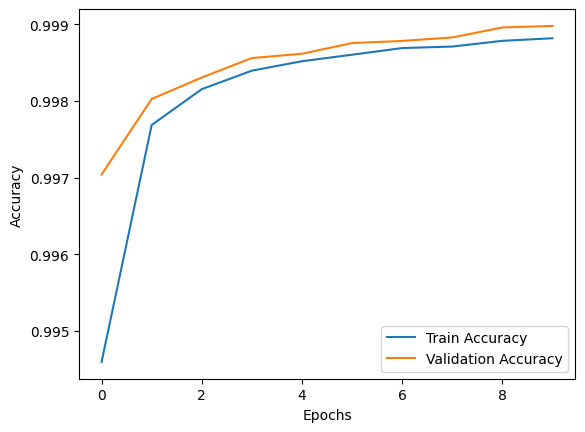

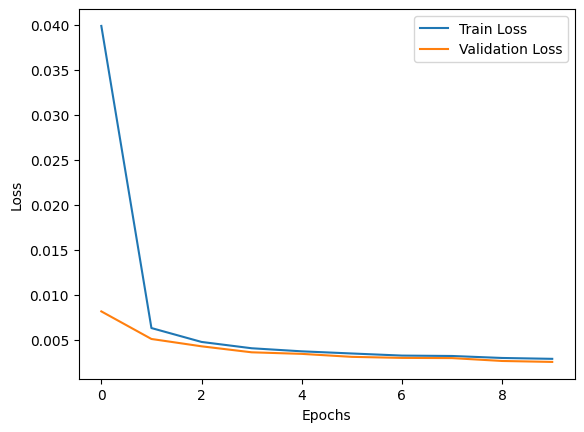

In [ ]:
# Draw Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Draw Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Classification Report

In [ ]:
prediction      = model.predict(x_test)
prediction      = (prediction > 0.5).astype('int')
print(classification_report(y_test.flatten(), prediction.flatten(), target_names=['No change', 'change']))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
              precision    recall  f1-score   support

   No change       1.00      1.00      1.00  23052752
      change       0.89      0.81      0.85     81456

    accuracy                           1.00  23134208
   macro avg       0.95      0.90      0.92  23134208
weighted avg       1.00      1.00      1.00  23134208



In [ ]:
# Save Model
model.save('model.h5')